In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv("churn_data.csv")
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Удаление столбца CustomerId

df.drop(["CustomerId", "RowNumber"], axis=1, inplace=True)
df.head(5)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Разбивка датасета на train и test 

X = df.drop("Exited", axis=1)
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# Сборка пайплайна

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
# Создание списка признаков 

categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
# Создание трансформера

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())])
    final_transformers.append((cont_col, cont_transformer))

In [8]:
# Объединение в единый пайплайн

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### Random Forest Classifier

In [9]:
# Добавление RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [10]:
# Обучение пайплайна

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [11]:
# Прогноз вероятностей для тестовой выборки

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [12]:
# Функция расчета метрик

def cal_metrics(y_test, preds):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, preds)
    
    metrics = (roc_auc, fscore[ix], precision[ix], recall[ix])
    thresholds = thresholds[ix]
    
    return metrics, thresholds

In [13]:
# Расчет метрик

metrics_forest, thresholds_forest = cal_metrics(y_test, preds)

metrics_forest

(0.8636990228128739, 0.6412825651302605, 0.65439672801636, 0.6286836935166994)

In [14]:
# Функция, рисующая матрицу ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


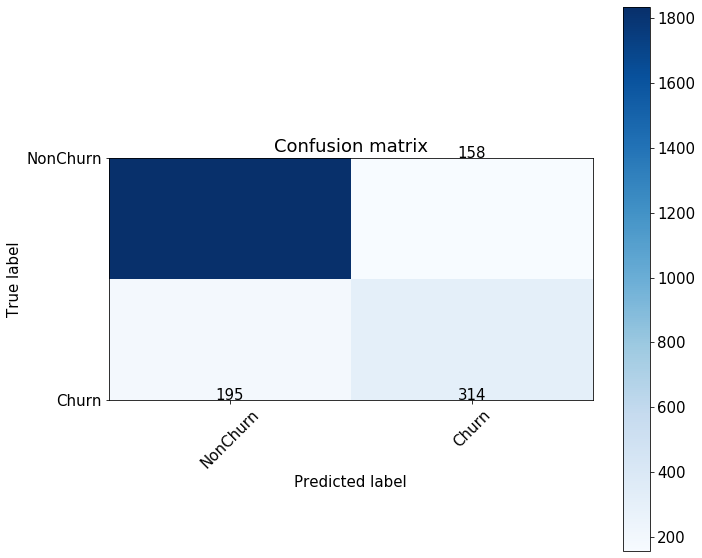

In [15]:
# Матрица ошибок

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_forest)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### LGBM Classifier

In [16]:
# Добавление LGBMClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42)),
])

In [17]:
# Обучение пайплайна

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [18]:
# Прогноз вероятностей для тестовой выборки

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.32348985, 0.26240682, 0.15107228, 0.04136097, 0.03068904,
       0.83729385, 0.04857496, 0.13178139, 0.12247852, 0.74362567])

In [19]:
# Расчет метрик

metrics_lgbm, thresholds_lgbm = cal_metrics(y_test, preds)

metrics_lgbm

(0.8718723450024126,
 0.6437994722955145,
 0.5828025477707006,
 0.7190569744597249)

Confusion matrix, without normalization
[[1729  262]
 [ 144  365]]


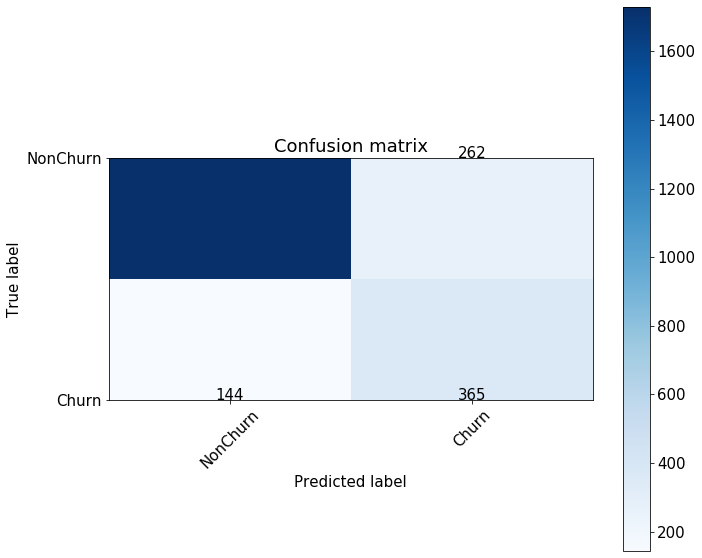

In [20]:
# Матрица ошибок

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_lgbm)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Logistic Regression

In [21]:
# Добавление LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [22]:
# Обучение пайплайна

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [23]:
# Прогноз вероятностей для тестовой выборки

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [24]:
# Расчет метрик

metrics_logreg, thresholds_logreg = cal_metrics(y_test, preds)

metrics_logreg

(0.7720774921330664, 0.5097001763668431, 0.4624, 0.5677799607072691)

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


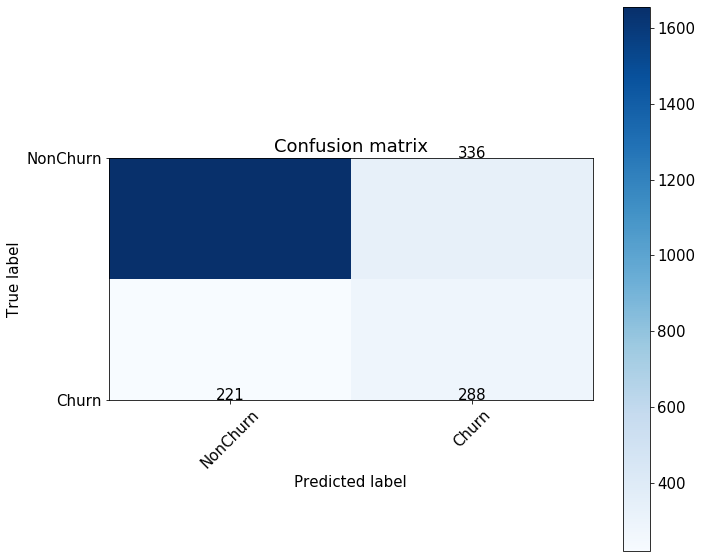

In [25]:
# Матрица ошибок

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_logreg)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [26]:
all_metrics = (metrics_forest, metrics_lgbm, metrics_logreg)

table = pd.DataFrame(list(all_metrics), columns=['roc-auc', 'f-score', 'precision', 'recall'], index=['RandomForestClassifier', 'LGBMClassifier', 'LogisticRegression'])

In [27]:
table

,roc-auc,f-score,precision,recall
RandomForestClassifier,0.863699,0.641283,0.654397,0.628684
LGBMClassifier,0.871872,0.643799,0.582803,0.719057
LogisticRegression,0.772077,0.509700,0.462400,0.567780


LGBM Classifier показывает лучшие результаты по метрикам roc-auc и f-score (precision и recall не учитываем, так как их в себе учитывает f-score)

### Оценка экономической эффективности модели

In [28]:
# Матрица ошибок при использовании LGBM Classifier

TP = 1729     
FP = 262
FN = 144       
TN = 365

In [29]:
# Не уверена, что правильно поняла условия задания
# Тратим 1$ на каждого True и False Positive, но получаем 2$ дохода с каждого True positive

efficiency = TP * 2 - TP - FP
print(f'Доход от использовния модели: {efficiency}$')

Доход от использовния модели: 1467$
